In [1]:
# This line solves some minor problems when you do not have propery set the PYTHONPATH
exec(compile(open("../fix_paths.py", "rb").read(), "fix_paths.py", 'exec'))
from generator_settings import *
import tensorflow as tf 
import keras
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 1.
config.gpu_options.allow_growth = True
set_session(tf.Session(config=config))



from files_of_data_creator import start_file_generator_process
from generator_settings import *
from network_data_generator import data_generator
import settings
import os
import pandas as pd
from common import dataset_loaders
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
import time
from sklearn import metrics
from keras import backend as K

K.set_image_dim_ordering('th')

from keras.optimizers import Adam
from dl_utils.dl_networks.resnet import ResnetBuilder
from keras import losses
#from dl_utils.tb_callback import TensorBoard


#data_augmentation = ImageDataGenerator(vertical_flip=True, horizontal_flip = True, zoom_range = 0.00, rotation_range=180)


# Load model
model = ResnetBuilder().build_resnet_50((3,image_size_nn,image_size_nn),len(class_to_index)+1)
model.compile(optimizer=Adam(lr=1e-4), metrics = [losses.kullback_leibler_divergence], loss=losses.kullback_leibler_divergence)#,'fmeasure'])
model.load_weights(OUTPUT_MODEL)


Using TensorFlow backend.
/home/jose/tech/ml_projects/kaggle/sealions_contest/dl_utils/dl_networks/resnet.py:44: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(kernel_size=(7, 7), filters=64, strides=(2, 2), padding="same", kernel_initializer="he_normal", kernel_regularizer=<keras.reg...)`
  init=init, border_mode=border_mode, W_regularizer=W_regularizer)(input)
/home/jose/tech/ml_projects/kaggle/sealions_contest/dl_utils/dl_networks/resnet.py:211: UserWarning: Update your `MaxPooling2D` call to the Keras 2 API: `MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding="same")`
  pool1 = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), border_mode="same")(conv1)
/home/jose/tech/ml_projects/kaggle/sealions_contest/dl_utils/dl_networks/resnet.py:147: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(kernel_size=(1, 1), filters=64, strides=(1, 1), padding="same", kernel_initializer="he_normal", kernel_regularizer=<keras.reg...)`
  W_regularizer=l2(0.0001))

In [4]:
from common import dataset_loaders
from pylab import *
%pylab inline

original_labels = dataset_loaders.groundlabels_dataframe()

Populating the interactive namespace from numpy and matplotlib


/home/jose/tech/anaconda3/envs/kgsealions/lib/python3.6/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['fft', 'linalg', 'info', 'random', 'power']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [3]:
x0,x1,y0,y1 = 250,750,250,750

data = dataset_loaders.load_image('616')
subdata = data[x0:x1,y0:y1,:]

In [59]:
import scipy
patch_size = 80

data = []
rows = 0
for i in range(int(patch_size/2), subdata.shape[0]-int(patch_size/2), 20):
    rows += 1
    for j in range(int(patch_size/2), subdata.shape[1]-int(patch_size/2), 20):
        data.append(scipy.misc.imresize(subdata[i-int(patch_size/2):i+int(patch_size/2),j-int(patch_size/2):j+int(patch_size/2),:], [image_size_nn, image_size_nn]) / 255)
    
preds = model.predict(np.array(data).transpose(0,3,1,2))
preds = preds.reshape([int(preds.shape[0] / rows), -1, preds.shape[1]])

In [77]:
window_size = 80
rec_size = 20
scan_window = 20
def reconstruct_original(img, preds, i_class):
    rec_im = np.zeros(img.shape[:2])
    for i in range(int(window_size/2),img.shape[0]-int(window_size/2),scan_window):
        for j in range(int(window_size/2),img.shape[1]-int(window_size/2),scan_window):
            x, y = int(int(i-window_size/2) / scan_window), int(int(j-window_size/2) / scan_window)
            value = preds[x,y][i_class]
            rec_im[i-int(rec_size/2):i+int(rec_size/2),j-int(rec_size/2):j+int(rec_size/2)] += value
    return rec_im

recs = np.array([reconstruct_original(subdata, preds, i) for i in range(6)])

#figure(figsize = (10,30))
#for i in range(6):
#    subplot(6,2,1+i*2)
#    imshow(subdata)
#    subplot(6,2,1+i*2+1)
#    red = reconstruct_original(subdata, preds, i)
#    imshow(red, cmap = cm.Reds)

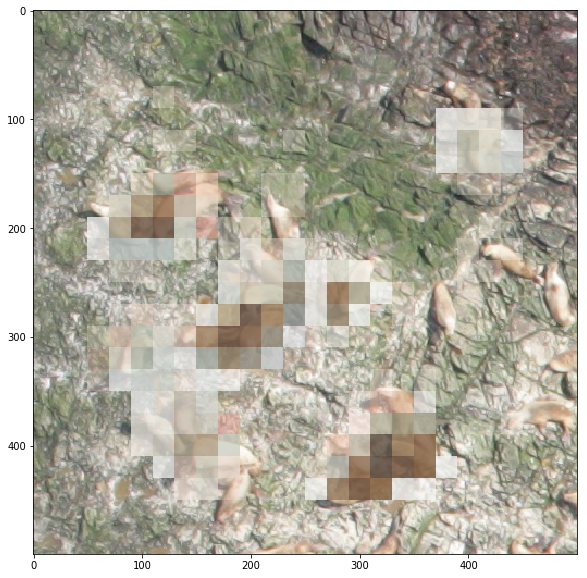

In [109]:
figure(figsize = (10,10))
imshow(subdata)
colors = [cm.Reds, cm.Greens, cm.Blues, cm.Greys, cm.Oranges]
for i in range(5):
    red = reconstruct_original(subdata, preds, i)
    red[red < 0.01] = np.nan
    imshow(red, cmap = colors[i], alpha = 0.3)

# Distribution is shit... lets look again at the row classifier

Populating the interactive namespace from numpy and matplotlib


/home/jose/tech/anaconda3/envs/kgsealions/lib/python3.6/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['random', 'info', 'fft', 'linalg', 'power']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


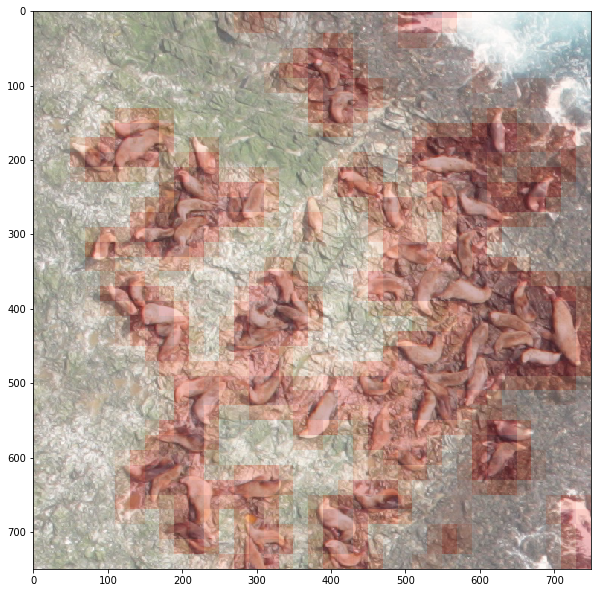

In [27]:
# This line solves some minor problems when you do not have propery set the PYTHONPATH
exec(compile(open("../fix_paths.py", "rb").read(), "fix_paths.py", 'exec'))
from generator_settings import *
from common import dataset_loaders

window_size = 80
rec_size = 40
scan_window = 20
case = '616'


original_labels = dataset_loaders.groundlabels_dataframe()
x0,x1,y0,y1 = 250,1000,250,1000
data = dataset_loaders.load_image(case)
subdata = data[x0:x1,y0:y1,:]
preds = np.load(annotations_path+'/sfinder_%s_20.npz' % case)['preds']

def reconstruct_original(img, preds, i_class):
    rec_im = np.zeros(img.shape[:2])
    for i in range(int(window_size/2),img.shape[0]-int(window_size/2),scan_window):
        for j in range(int(window_size/2),img.shape[1]-int(window_size/2),scan_window):
            x, y = int(int(i-window_size/2) / scan_window), int(int(j-window_size/2) / scan_window)
            value = preds[x,y][i_class]
            rec_im[i-int(rec_size/2):i+int(rec_size/2),j-int(rec_size/2):j+int(rec_size/2)] += value
    return rec_im

recs = reconstruct_original(data, preds, 0)[x0:x1,y0:y1]

from pylab import *
%pylab inline


figure(figsize = (10,30))
imshow(subdata)
imshow(recs, cmap = cm.Reds, alpha = 0.3)